## Design, Implementation, and Deployment of a Deep Learning Based Custom Image Multi-Class Classifier

### Objectives

This research seeks to design a deep learning-based custom image multi-class classifier optimized for a handwriting dataset, examine the influences of various architectures and hyperparameters on classifier performance, provide an illustrative guide on the classifier's implementation and deployment.

### Methodology

In this experiment, three distinct deep learning architectures were adopted to ascertain their effectiveness and adaptability in custom image multi-class classification. Each architecture, with its unique design principles and structural nuances, provides a varied perspective on the challenges and intricacies of image classification.  ResNet50, DenseNet121, and EfficientNetB0 were employed


### Dataset 

The National Institute of Standards and Technology (NIST) has a rich history of providing datasets that have become benchmarks in the field of machine learning and pattern recognition. Among these, the NIST Special Database 19 stands out as a comprehensive repository of handwritten characters, which has been pivotal for handwriting recognition research.

The “by_class.zip” subset of this database presents an organized collection of handwritten samples. As the name suggests, this subset categorizes samples "by class", where each class corresponds to a unique character or numeral. The dataset encompasses: Uppercase English alphabets A-Z, Lowercase English alphabets: a-z and Numerals: 0-9.
Each class is stored in its respective subdirectory, labeled by the hexadecimal Unicode value of the character it represents. For instance, the directory named “41” contains samples of the uppercase letter 'A', given that 'A' corresponds to the hexadecimal Unicode value of 41. Within these directories, a multitude of image files are present, each depicting a handwritten instance of the respective character, in this case the letter ‘A’. These samples, sourced from various writers, capture the variability and nuances of human handwriting, making the dataset representative of real-world scenarios.

For the aims of our study, we will specifically harness the directories "41", "42", and "43", representing the uppercase letters ‘A’, ‘B’, and ‘C’ respectively. The decision to focus on these three classes, from the available 62 classes, aims to showcase the model's potential while optimizing for training efficiency and computational resources.


### Data Processing

In [ ]:
# Import relevant libraries
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Specify the path to the root of the by_class dataset
dataset_path = './by_class'

# Define architectures to experiment with
architectures = ["ResNet50", "DenseNet121", "EfficientNetB0"]  # Extend this list as needed

results = {}

# Lists to store image file paths and their corresponding image labels
image_paths = []
image_labels = []

# List of folder names to be considered
selected_folders = ['41', '42', '43']

# Traverse through each main subdirectory in the by_class dataset
for main_subdir in os.listdir(dataset_path):
    # Check if the folder is one of the selected folders
    if main_subdir in selected_folders:
        main_subdir_path = os.path.join(dataset_path, main_subdir)
        
        # Check if it's a directory (to ignore any non-directory entities)
        if os.path.isdir(main_subdir_path):
            # Convert the hexadecimal value to its corresponding character for label assignment
            label = chr(int(main_subdir, 16))
            
            # Traverse through the nested subdirectories
            for nested_subdir in os.listdir(main_subdir_path):
                nested_subdir_path = os.path.join(main_subdir_path, nested_subdir)
                
                if os.path.isdir(nested_subdir_path):
                    # Traverse through each image file in the nested subdirectory
                    for image_file in os.listdir(nested_subdir_path):
                        if image_file.endswith('.png'):
                            image_file_path = os.path.join(nested_subdir_path, image_file)
                            
                            # Append the image path and its label to the respective lists
                            image_paths.append(image_file_path)
                            image_labels.append(label)




### Image Processing

In [3]:
# Lists to store preprocessed images
processed_images = []

# Process each image
for image_path in image_paths:
    # Load image using PIL
    image = Image.open(image_path)
    
    # Convert to grayscale
    image = image.convert('L')
    
    # Resize to 32x32
    image = image.resize((32, 32))
    
    # Convert to numpy array and normalize pixel values to [0,1]
    image_array = np.array(image) / 255.0
    
    # Append to processed_images list
    processed_images.append(image_array)

# Convert processed_images to a numpy array for easier manipulation later
processed_images = np.array(processed_images)

# Print out the shape to verify
print(f"Processed images shape: {processed_images.shape}")

Processed images shape: (46244, 32, 32)


### One-Hot Encoding

In [5]:
# Creating a list of labels for our dataset
labels = list('ABC')

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the label encoder on the unique labels and transform the original labels
integer_encoded = label_encoder.fit_transform(labels)

# Ensure that the integer_encoded labels range from 0 to 2
assert integer_encoded.max() == 2

# Convert integer labels to one-hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
one_hot_labels = onehot_encoder.fit_transform(integer_encoded)

label_binarizer = LabelBinarizer()
one_hot_labels = label_binarizer.fit_transform(image_labels)


(3, 3)


/Users/dacawave/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Data Augmentation and Model Training

In [7]:
# 1. Convert grayscale images to RGB format
processed_images_rgb = np.repeat(processed_images[..., np.newaxis], 3, -1)

# 2. Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# 3. Data Splitting
X_temp, X_test, y_temp, y_test = train_test_split(processed_images_rgb, one_hot_labels, test_size=0.1, stratify=one_hot_labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, stratify=y_temp)

# Define architectures to experiment with
architectures = ["ResNet50", "DenseNet121", "EfficientNetB0"]
results = {}

# Callbacks:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

for arch in architectures:
    # 4. Model Definition
    if arch == "ResNet50":
        base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(32,32,3))
    elif arch == "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape=(32,32,3))
    elif arch == "EfficientNetB0":
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights=None, input_shape=(32,32,3))

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    predictions = tf.keras.layers.Dense(3, activation='softmax')(x)  # Assuming 3 classes
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile, Train, and Evaluate
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        validation_data=(X_val, y_val),
                        epochs=30,
                        steps_per_epoch=len(X_train) // 32,
                        callbacks=[early_stopping, model_checkpoint])
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    results[arch] = {
        "history": history.history,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

# Analyze results
for arch, data in results.items():
    print(f"Architecture: {arch}")
    print(f"Test Accuracy: {data['test_accuracy']*100:.2f}%")
    # ... Further analysis, plotting, etc.


Epoch 1/30
1170/1170 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.9206
Epoch 1: val_loss improved from inf to 0.09960, saving model to best_model.h5


/Users/dacawave/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1170/1170 [==============================] - 1310s 1s/step - loss: 0.2803 - accuracy: 0.9206 - val_loss: 0.0996 - val_accuracy: 0.9659
Epoch 2/30
1170/1170 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9675
Epoch 2: val_loss improved from 0.09960 to 0.06161, saving model to best_model.h5
1170/1170 [==============================] - 3107s 3s/step - loss: 0.1019 - accuracy: 0.9675 - val_loss: 0.0616 - val_accuracy: 0.9808
Epoch 3/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9846
Epoch 3: val_loss did not improve from 0.06161
1170/1170 [==============================] - 502s 429ms/step - loss: 0.0524 - accuracy: 0.9846 - val_loss: 0.1333 - val_accuracy: 0.9592
Epoch 4/30
1170/1170 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9717
Epoch 4: val_loss did not improve from 0.06161
1170/1170 [==============================] - 467s 399ms/step - loss: 0.1002 - accuracy: 0.9717 - val_loss: 0.0726 - val_acc

1170/1170 [==============================] - 206s 176ms/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0105 - val_accuracy: 0.9981
Epoch 15/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9967
Epoch 15: val_loss did not improve from 0.01047
1170/1170 [==============================] - 208s 177ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.0146 - val_accuracy: 0.9957
Epoch 16/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9964
Epoch 16: val_loss did not improve from 0.01047
1170/1170 [==============================] - 207s 177ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0145 - val_accuracy: 0.9959
Epoch 17/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9971
Epoch 17: val_loss improved from 0.01047 to 0.00974, saving model to best_model.h5
1170/1170 [==============================] - 210s 179ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0097

Epoch 13/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9932
Epoch 13: val_loss did not improve from 0.00445
1170/1170 [==============================] - 95s 82ms/step - loss: 0.0240 - accuracy: 0.9932 - val_loss: 0.0274 - val_accuracy: 0.9914
Epoch 14/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9939
Epoch 14: val_loss did not improve from 0.00445
1170/1170 [==============================] - 97s 83ms/step - loss: 0.0213 - accuracy: 0.9939 - val_loss: 0.0669 - val_accuracy: 0.9762
Epoch 15/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9950
Epoch 15: val_loss did not improve from 0.00445
1170/1170 [==============================] - 97s 83ms/step - loss: 0.0194 - accuracy: 0.9950 - val_loss: 0.0326 - val_accuracy: 0.9918
Epoch 16/30
1170/1170 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9938
Epoch 16: val_loss did not improve from 0.00445
1170/11

### Performance Visualization

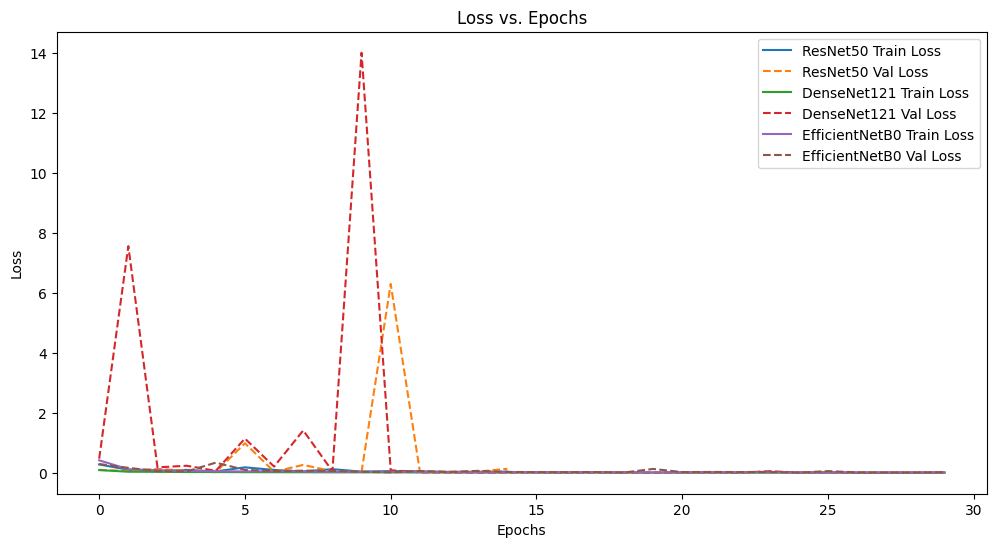

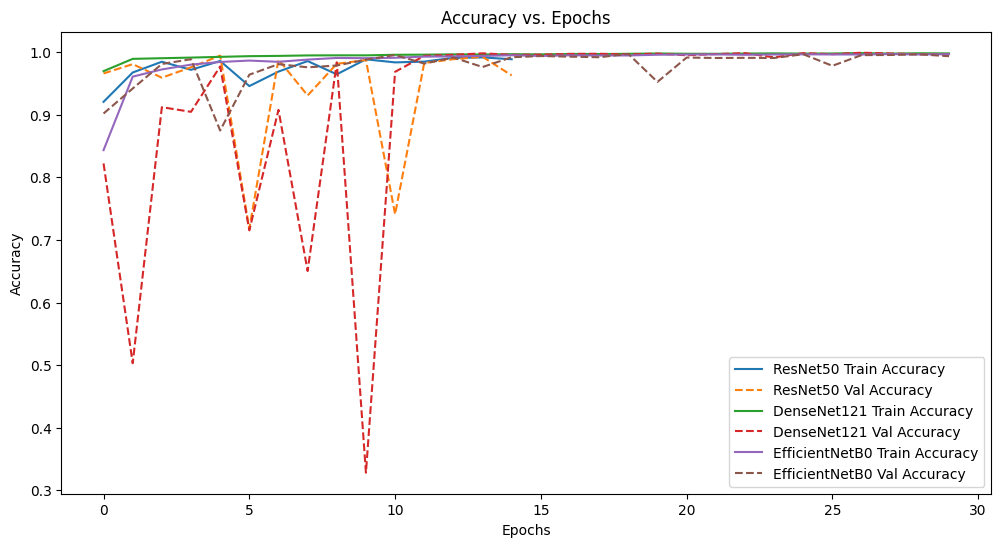

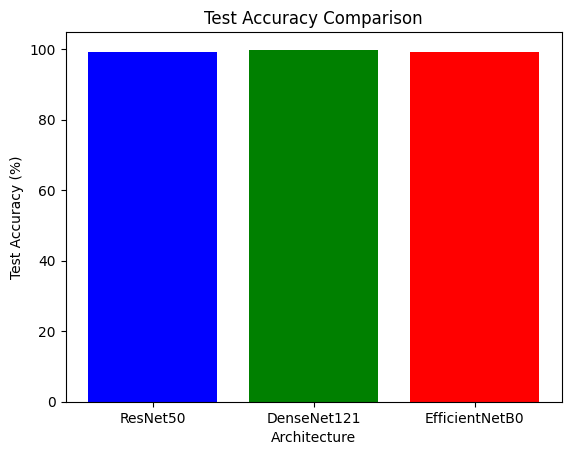

In [8]:
import matplotlib.pyplot as plt

# 1. Loss Plots
plt.figure(figsize=(12, 6))
for arch, data in results.items():
    plt.plot(data['history']['loss'], label=f"{arch} Train Loss")
    plt.plot(data['history']['val_loss'], label=f"{arch} Val Loss", linestyle='--')
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2. Accuracy Plots
plt.figure(figsize=(12, 6))
for arch, data in results.items():
    plt.plot(data['history']['accuracy'], label=f"{arch} Train Accuracy")
    plt.plot(data['history']['val_accuracy'], label=f"{arch} Val Accuracy", linestyle='--')
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 3. Test Accuracy Bar Chart
architectures = list(results.keys())
test_accuracies = [data['test_accuracy']*100 for _, data in results.items()]
plt.bar(architectures, test_accuracies, color=['blue', 'yellow', 'red'])
plt.xlabel('Architecture')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.show()


### Visualization for Augmented Data

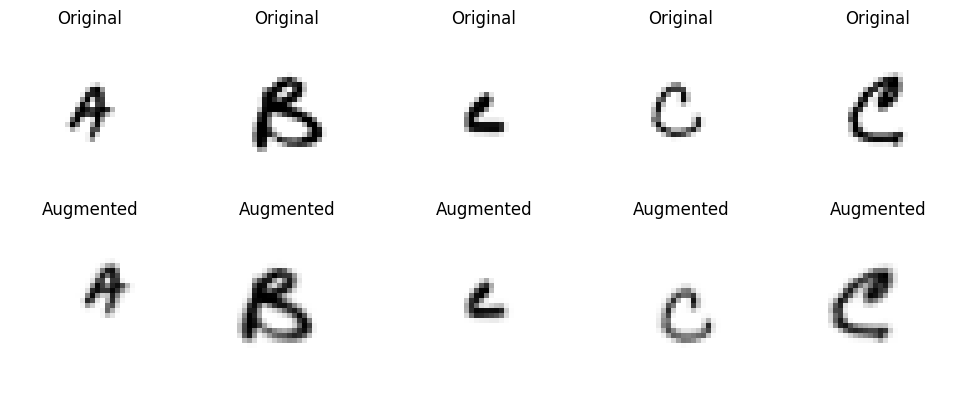

In [16]:
import matplotlib.pyplot as plt

# Choose a random sample of images
num_samples = 5
samples_indices = np.random.choice(X_train.shape[0], num_samples)
sample_images = X_train[samples_indices]

# Get augmented images
augmented_images = next(datagen.flow(sample_images, shuffle=False, batch_size=num_samples))

plt.figure(figsize=(10, 4))

for i in range(num_samples):
    # Original Image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis('off')
    
    # Augmented Image
    plt.subplot(2, num_samples, num_samples+i+1)
    plt.imshow(augmented_images[i])
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()
